In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.feature_selection import RFE

In [2]:
# Load dataset
data=pd.read_csv("C:\\Users\\mo69fon\\Small_Molecules_SP\\SM+PD2.csv")
data

,Name,Solubility parameter,number of repeating units,Molecular weight,Connectivity index 0X,Connectivity index 1X,Connectivity index 0Xv,Connectivity index 1Xv,Quadrupole moment,Atomization energy (kJ/mol),...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,"2,2,3,3-tetramethylbutane",14.58,1,114.000,6.414214,3.457107,6.414214,3.457107,-41.98,10230.26,...,4.390033,14.062500,1.757812,0.000000,0.000000,0.0,58,9,4.844,38
1,"2,2,3-trimethylbutane",14.07,1,100.000,5.491564,3.127827,5.491564,3.127827,-36.86,9031.25,...,4.353270,12.293055,1.756151,0.000000,0.000000,0.0,42,6,4.238,30
2,"2,2-dimethyl-3-hexanol",19.31,1,130.000,6.905777,4.127827,6.352991,3.808676,-45.38,10653.67,...,4.819843,16.266070,1.807341,2.430904,2.430904,0.0,92,9,2.361,38
3,"2,2-dimethyl-3-pentanol",19.57,1,116.000,6.198671,3.627827,5.645884,3.308676,-40.05,9437.67,...,4.838338,14.275065,1.784383,2.396386,2.396386,0.0,63,8,1.792,34
4,"2,2-dimethylbutane",13.75,1,86.000,4.621320,2.707107,4.621320,2.707107,-31.76,7826.93,...,4.305478,10.465990,1.744332,0.000000,0.000000,0.0,28,3,3.730,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2-methyl-3-pentanol,20.70,1,102.170,5.276021,3.304530,4.723234,2.985379,-35.58,8227.16,...,4.862117,12.505243,1.786463,2.394392,2.394392,0.0,46,6,1.397,26
311,3-methyl-2-pentanol,21.11,1,102.170,5.276021,3.304530,4.723234,2.985379,-34.75,8224.03,...,4.862117,12.505243,1.786463,2.348368,2.348368,0.0,46,6,1.608,26
312,4-methyl-2-pentanol,21.37,1,102.170,5.276021,3.287694,4.723234,2.968542,-36.18,8228.90,...,4.862117,12.509162,1.787023,2.353722,2.353722,0.0,48,4,1.819,26
313,"3,3-dimethyl-2-butanol",20.21,1,102.170,5.491564,3.127827,4.938777,2.808676,-34.78,8224.63,...,4.862117,12.293055,1.756151,2.327350,2.327350,0.0,42,6,1.434,30


In [3]:
# Remove descriptors with all 0 columns
newdata = data.loc[:, (data != 0).any(axis=0)]
print('----- after removing rows with only 0 -----')
print('new data shape:', data.shape)

----- after removing rows with only 0 -----
new data shape: (315, 1454)


In [4]:
# Define target values and variables
cols = list(newdata.columns)
x = newdata.iloc[:,2:]
y = newdata.iloc[:,1] 
paras = cols[2:]

In [5]:
#Convert it to a DataFrame
X = pd.DataFrame(x)

In [6]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Fill NaN values with column means
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [8]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.feature_selection import RFECV
# Apply RFECV to reduce dimensionality
lasso = Lasso(random_state=42)
rfecv = RFECV(estimator=lasso, step=1, cv=5, scoring='r2', n_jobs=-1)
X_train_rfecv = rfecv.fit_transform(X_train, y_train)
X_test_rfecv = rfecv.transform(X_test)

In [10]:
# Generate ranking for features
rfecv_ranking = pd.DataFrame({'Descriptors': paras, 'Ranking': rfecv.ranking_})
print(rfecv_ranking.sort_values('Ranking'))

                   Descriptors  Ranking
838                       hmax        1
861             ETA_dEpsilon_D        1
882                  ETA_Eta_L        1
124                     AATS1s        1
196                    AATSC1c        1
..                         ...      ...
4      Connectivity index 0Xv      1071
3       Connectivity index 1X      1072
2       Connectivity index 0X      1073
1             Molecular weight     1074
0    number of repeating units     1075

[1081 rows x 2 columns]


In [11]:
# Step 8: Print the number of features selected by RFECV
print(f'Number of features selected by RFECV: {rfecv.n_features_}')

Number of features selected by RFECV: 7


In [14]:
# Optional: To get the selected feature names
selected_features = pd.DataFrame(newdata).columns[2:][rfecv.support_]
print(f'Selected features: {selected_features}')

Selected features: Index(['AATS1s', 'AATSC1c', 'hmax', 'hmin', 'ETA_dEpsilon_D', 'ETA_Eta_L',
       'ETA_EtaP_L'],
      dtype='object')


In [15]:
from sklearn.neural_network import MLPRegressor
# Define the MLPRegressor model
mlp = MLPRegressor(max_iter=50000, random_state=42)

In [16]:
param_grid = {
    'mlp__hidden_layer_sizes': [(10,10)],
    'mlp__alpha': [0.1, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.01, 0.1],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam']
}

In [17]:
from sklearn.pipeline import Pipeline
# Create a pipeline for scaling and MLPRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Ensure the features are scaled again for the neural network
    ('mlp', mlp)
])

In [18]:
# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='r2')

In [19]:
# Fit the model on the training data
grid_search.fit(X_train_rfecv, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'mlp__activation': ['relu'], 'mlp__alpha': [0.1, 0.01], 'mlp__hidden_layer_sizes': [(10, ...)], 'mlp__learning_rate': ['constant', 'adaptive'], ...}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [20]:
num_runs=5
run_times_seconds=[]
for run in range(num_runs):
    start_time = time.time()
    grid_search.fit(X_train_rfecv, y_train)
    end_time = time.time()
    elapsed_time_sec = end_time - start_time
    run_times_seconds.append(elapsed_time_sec)
    elapsed_time_min = elapsed_time_sec / 60
    print(f"Run {run + 1}: {elapsed_time_sec:.2f} seconds ({elapsed_time_min:.2f} minutes)")
    
# Compute average and std dev
avg_sec = np.mean(run_times_seconds)
std_sec = np.std(run_times_seconds)
avg_min = avg_sec / 60
std_min = std_sec / 60

# Final output
print(f"\nAverage training time: {avg_sec:.2f} seconds ({avg_min:.2f} minutes)")
print(f"Standard deviation: {std_sec:.2f} seconds ({std_min:.2f} minutes)")

Run 1: 2.15 seconds (0.04 minutes)
Run 2: 2.16 seconds (0.04 minutes)
Run 3: 2.13 seconds (0.04 minutes)
Run 4: 2.14 seconds (0.04 minutes)
Run 5: 2.13 seconds (0.04 minutes)

Average training time: 2.14 seconds (0.04 minutes)
Standard deviation: 0.01 seconds (0.00 minutes)


In [21]:
# Retrieve the best parameters and the best estimator from the grid search
best_params = grid_search.best_params_
grid_result = grid_search.best_estimator_

In [22]:
grid_result

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"(10, ...)"
,activation,'relu'
,solver,'adam'


In [23]:
# Get the best model
best_model = grid_search.best_estimator_

In [24]:
# Make predictions
y_train_pred = best_model.predict(X_train_rfecv)
y_test_pred = best_model.predict(X_test_rfecv)

In [25]:
# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [26]:
train_r2

0.8996219362948774

In [27]:
test_r2

0.830428562452068

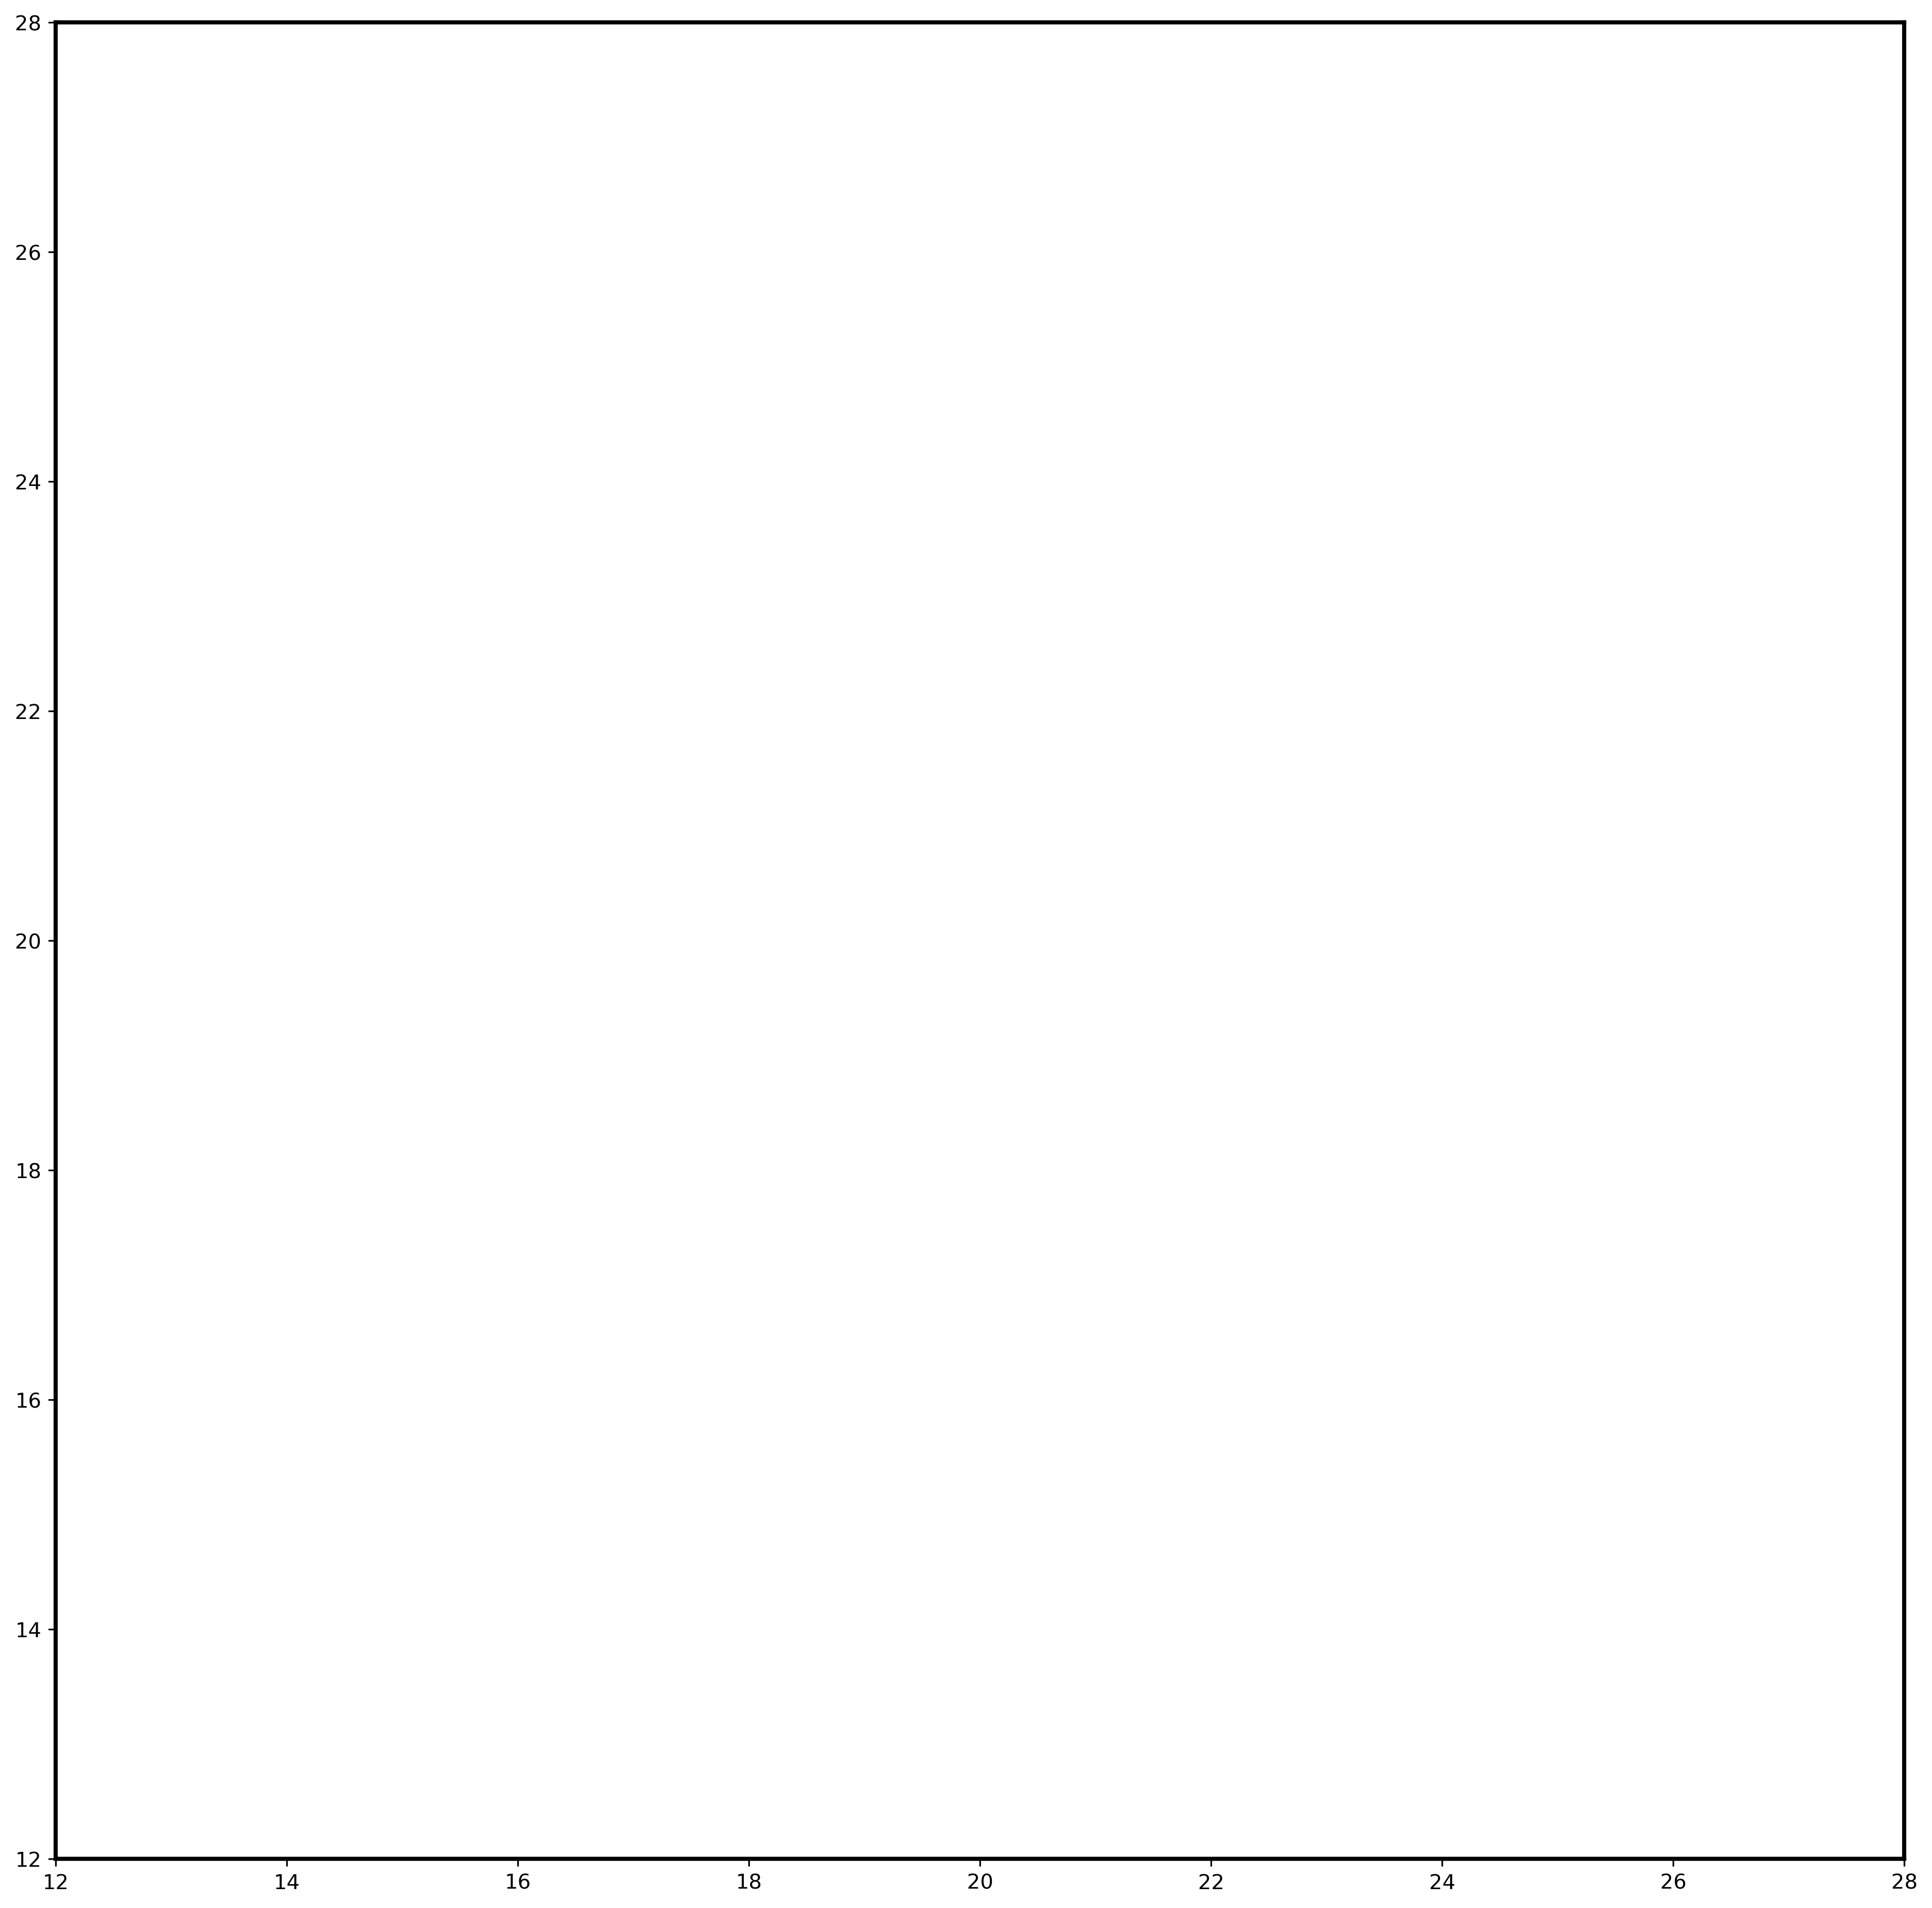

In [28]:
# Plot the predicted values versus the true values for the training and test sets
f, ax = plt.subplots(figsize=(16, 16),dpi=300)
plt.xlim((12, 28))
plt.ylim((12, 28))
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

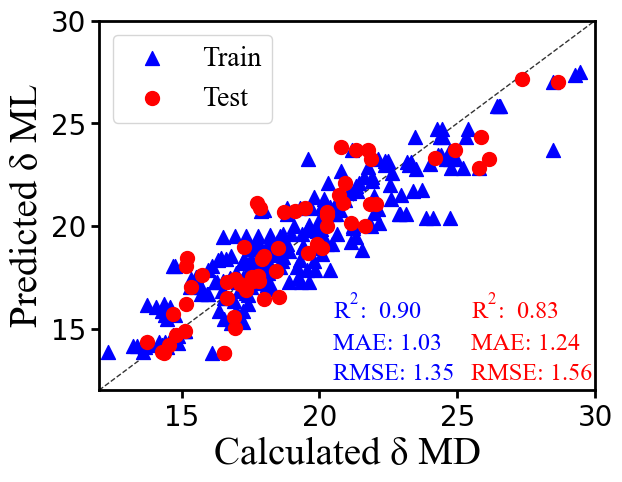

In [29]:
import matplotlib.pyplot as plt
orange_accent2 = (255/255, 192/255, 0/255)
plt.plot([12, 30], [12, 30], ls="--", c=".2", linewidth=1, zorder=1)
plt.scatter(y_train, y_train_pred, c='blue', marker='^', s=100, label='Train', zorder=2)
plt.scatter(y_test, y_test_pred, c='red', marker='o', s=100, label='Test', zorder=2)
plt.xlim(12, 30)
#plt.xticks([])
plt.ylim(12, 30)

# Set font properties
font_properties = {'family': 'Times New Roman', 'size': 28}

# Apply black border and customize ticks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(2)

# Increase tick size and label size
plt.tick_params(axis='both', which='major', labelsize=20, width=2, length=6)


plt.xlabel('Calculated δ MD',fontsize=28,family= 'Times New Roman')
plt.ylabel('Predicted δ ML',fontsize=28,family= 'Times New Roman')

# Legend
plt.legend(loc='upper left', prop={'size': 20, 'family': 'Times New Roman'})

plt.annotate("$\mathregular {{R^{{2}}}}$: {:5.2f}".format(test_r2),
        (22, 14), xytext=(25.5, 15.5),
        fontsize=17.5,family= 'Times New Roman',c='red')
plt.annotate("MAE:{:5.2f}".format(test_mae),
        (22, 14), xytext=(25.5, 14),
        fontsize=17.5,family= 'Times New Roman',c='red')
plt.annotate("RMSE:{:5.2f}".format(test_rmse),
        (22, 14), xytext=(25.5, 12.5),
        fontsize=17.5,family= 'Times New Roman',c='red')
plt.annotate("$\mathregular {{R^{{2}}}}$: {:5.2f}".format(train_r2),
        (22, 14), xytext=(20.5, 15.5),
        fontsize=17.5,family= 'Times New Roman',c='blue')
plt.annotate("MAE:{:5.2f}".format(train_mae),
        (22, 14), xytext=(20.5, 14),
        fontsize=17.5,family= 'Times New Roman',c='blue')
plt.annotate("RMSE:{:5.2f}".format(train_rmse),
        (22, 14), xytext=(20.5, 12.5),
        fontsize=17.5,family= 'Times New Roman',c='blue')
#plt.title('RFECV_NN',x=0.5,y=1.01,fontsize=25,family= 'Times New Roman')
#plt.savefig('NN_RFECV_paper.png', bbox_inches='tight', dpi=800)
plt.show()

In [30]:
# output scores and best parameters
print("Train R2 Score:", train_r2)
print("Test R2 Score:", test_r2)
print("Train MAE Score:", train_mae)
print("Test MAE Score:", test_mae)
print("Train RMSE Score:", train_rmse)
print("Test RMSE Score:", test_rmse)
print('best_params_')
print(best_params)

Train R2 Score: 0.8996219362948774
Test R2 Score: 0.830428562452068
Train MAE Score: 1.0316271443097558
Test MAE Score: 1.2354388078062926
Train RMSE Score: 1.3462092051484338
Test RMSE Score: 1.5603694843366165
best_params_
{'mlp__activation': 'relu', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (10, 10), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.1, 'mlp__solver': 'adam'}
